## General imports and functions

In [ ]:
import networkx as nx
import json
import pandas as pd
import os
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

In [ ]:
def cyjs2graph(cyjs_file_name):
    #Read json
    cyjson = json.load(open(cyjs_file_name))
    #Read nodes and make a dictionary of names
    name_from_id,code_from_id = {},{}
    for node in cyjson["elements"]["nodes"]:
        code_from_id[node['data']['id']] = node['data']['name']
        name_from_id[node['data']['id']] = node['data']['display_name']#Name of the nodes are assumed to be in the "display_name" key

    #Create network
    g = nx.Graph()
    #The assumption next is that nodes has just one name, otherwise the following exception rises
    try:
        assert len(set(code_from_id))==len(set(name_from_id))
    except:
        raise Exception('Names are redundant')

    #Add nodes
    for n in set(name_from_id.values()):
        g.add_node(n)

    #Add edges
    for edge in cyjson["elements"]["edges"]:
        src_id = edge['data']['source']
        src_name = name_from_id[src_id]
        tgt_id   = edge['data']['target']
        tgt_name = name_from_id[tgt_id]
        #Add "stringdb_score" as edge weight
        weight = edge['data']["stringdb_score"]
        if weight>0:
            g.add_weighted_edges_from([(src_name,tgt_name,weight)])
        #
    return(g)

## Early intersection

### Transcripts

In [ ]:
def data_preprocessing(dir, stats_name, genenames_file):
    # reading the data
    df = pd.read_csv(os.path.join(dir, stats_name)).reset_index()
    df.drop(columns=["ClusteringCoefficient"], inplace=True)
    df.columns = ["string_id"] + list(df.columns[2:]) + ["ClusteringCoefficient"]
    # reading and adding correct names
    df_names = pd.read_csv(os.path.join(dir, genenames_file), header=None)
    df_names.columns = ['string_id', 'protein_name']
    df = pd.merge(df, df_names, how="right", on = ["string_id"])
    return df

dir = "/home/anna/Downloads/OE33_project/Proteomics_20230721d_JR_HS_METTL1_KO/reps3nc2_analysis/early_prot_inters"
early_int_trs = data_preprocessing(dir, "early_inters_trs.csv", "early_inters_trs_names.csv")
early_int_trs.head()

,string_id,MCC,DMNC,MNC,Degree,EPC,BottleNeck,EcCentricity,Closeness,Radiality,Betweenness,Stress,ClusteringCoefficient,protein_name
0,9606.ENSP00000356520,8.918670e+05,0.35333,52.0,53.0,97.050,9.0,0.20000,238.15000,5.54386,5803.21914,67438.0,0.21190,DHX9
1,9606.ENSP00000371786,1.000000e+00,0.00000,1.0,1.0,2.313,1.0,0.16667,131.83333,3.97856,0.00000,0.0,0.00000,ONECUT3
2,9606.ENSP00000310561,2.000000e+00,0.00000,1.0,2.0,5.896,2.0,0.20000,157.48333,4.56920,665.43018,4806.0,0.00000,ARHGAP32
3,9606.ENSP00000346725,9.223372e+13,0.91296,51.0,52.0,107.855,2.0,0.20000,223.23333,5.33138,780.25564,14540.0,0.55053,PES1
4,9606.ENSP00000321449,9.223372e+13,1.03262,30.0,31.0,93.156,1.0,0.20000,207.85000,5.21832,191.49032,4310.0,0.72043,RRP7A


In [ ]:
def top_matrix(df, n=100):
    # selecting the top-100 nodes for each metric
    top_dict = dict()
    #to infer the most distinct type of metric, we can calculate sum of its intersections
    #summ_metrix = dict()
    for metric in list(df.columns[1:-1]):
        top_dict[metric] = list(df.sort_values(by=metric, ascending=False).head(n)['protein_name'])

    # matrix looks better
    matrix_inters = pd.DataFrame(columns=df.columns[1:-1], index=df.columns[1:-1])
    for method1 in df.columns[1:-1]:
        for method2 in df.columns[1:-1]:
            matrix_inters[method1][method2] = len(set(top_dict[method1]).intersection(set(top_dict[method2])))
    matrix_inters = matrix_inters.astype(float)

    return top_dict, matrix_inters

In [ ]:
top_100_dict, matrix_inters_trs = top_matrix(early_int_trs)

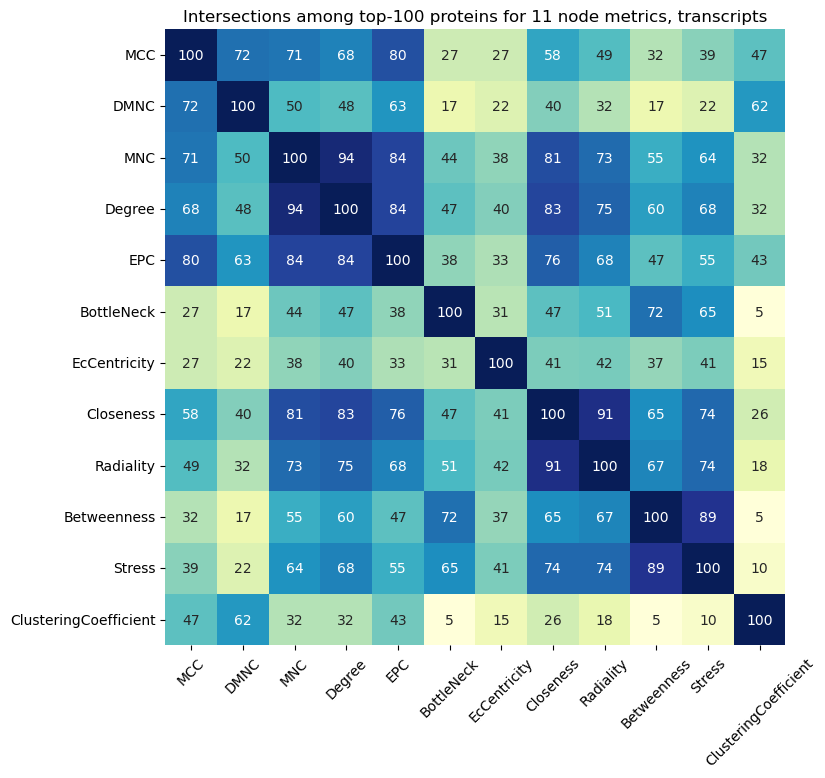

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(matrix_inters_trs, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)
plt.title('Intersections among top-100 proteins for 11 node metrics, transcripts')
plt.xticks(rotation=45)
plt.show()

In [ ]:
matrix_inters_trs.sum(axis=1) - 100

MCC                      570.0
DMNC                     445.0
MNC                      686.0
Degree                   699.0
EPC                      671.0
BottleNeck               444.0
EcCentricity             367.0
Closeness                682.0
Radiality                640.0
Betweenness              546.0
Stress                   601.0
ClusteringCoefficient    295.0
dtype: float64

In [ ]:
# intersection of all metrics except DMNC, ClusteringCoefficient, and EcCentricity

full_intersectiont = set.intersection(*(set(top_100_dict[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))
print(*[i+"," for i in sorted(full_intersectiont)])
len(full_intersectiont)

CEBPZ, DHX9, DKC1, EIF5B, ELAVL1, KRR1, LDHA, MRTO4, PA2G4, PNPT1, POLR1A, POLR2E, RPL13, RPS16, RPS23, RRS1, UBQLN2, XRN2,


18

In [ ]:
# for top 200
top_200_dictt, _ = top_matrix(early_int_trs, 200)

full_intersectiont = set.intersection(*(set(top_200_dictt[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))
print(*[i+"," for i in sorted(full_intersectiont)])
print(len(full_intersectiont), "key proteins overall\n")

ACO1, AFG3L2, AGO2, AK1, ALYREF, ASS1, CEBPZ, CLTC, CREBBP, CTCF, CYC1, CYCS, DDX60, DHX9, DKC1, EIF4E, EIF5B, ELAVL1, FASN, FEN1, GLUD1, GNL1, GSK3B, GUF1, H6PD, HNRNPD, HSP90AA1, HSPA1B, HSPD1, IARS2, IDH2, IGF2BP2, IRS1, JUP, KRR1, LDHA, LSM8, MCM3, MDC1, MRPL3, MRPL47, MRTO4, NOC4L, NOP2, NUMA1, NUP107, NUP133, OAT, PA2G4, PES1, PGK1, PNPT1, POLR1A, POLR2E, PSMD12, PSMG1, PUS1, PYGB, RICTOR, RPL13, RPL7, RPLP1, RPS16, RPS23, RPS26, RPS29, RRS1, SERBP1, SIN3A, SLC2A1, SMC3, SRRT, TP53BP1, TRIM28, TXN, UBQLN2, UPF1, URB1, WDR12, XRCC1, XRCC5, XRN2,
82 key proteins overall



### Genes

In [ ]:
dir = "/home/anna/Downloads/OE33_project/Proteomics_20230721d_JR_HS_METTL1_KO/reps3nc2_analysis/early_prot_inters"
early_int_genes = data_preprocessing(dir, "early_inters_genes_stat.csv", "early_inters_genes_names.csv")
early_int_genes.head()

,string_id,MCC,DMNC,MNC,Degree,EPC,BottleNeck,EcCentricity,Closeness,Radiality,Betweenness,Stress,ClusteringCoefficient,protein_name
0,9606.ENSP00000001008,12881.0,0.42988,20.0,21.0,8.368,1.0,0.20000,415.53333,5.40851,1299.64145,20708.0,0.33333,FKBP4
1,9606.ENSP00000003100,150.0,0.29378,13.0,13.0,4.179,2.0,0.20000,384.85000,5.22849,935.95047,13852.0,0.29487,CYP51A1
2,9606.ENSP00000005386,41309.0,0.40532,20.0,21.0,11.247,1.0,0.20000,409.93333,5.36103,643.86772,14172.0,0.31429,RPAP3
3,9606.ENSP00000012049,3.0,0.30779,2.0,3.0,1.859,1.0,0.20000,329.33333,4.77250,8.84855,184.0,0.33333,QPCTL
4,9606.ENSP00000013125,2.0,0.00000,1.0,2.0,1.167,1.0,0.16667,294.15000,4.44214,38.79398,312.0,0.00000,MAP4K5


In [ ]:
top_100_dictg, matrix_inters_genes = top_matrix(early_int_genes)

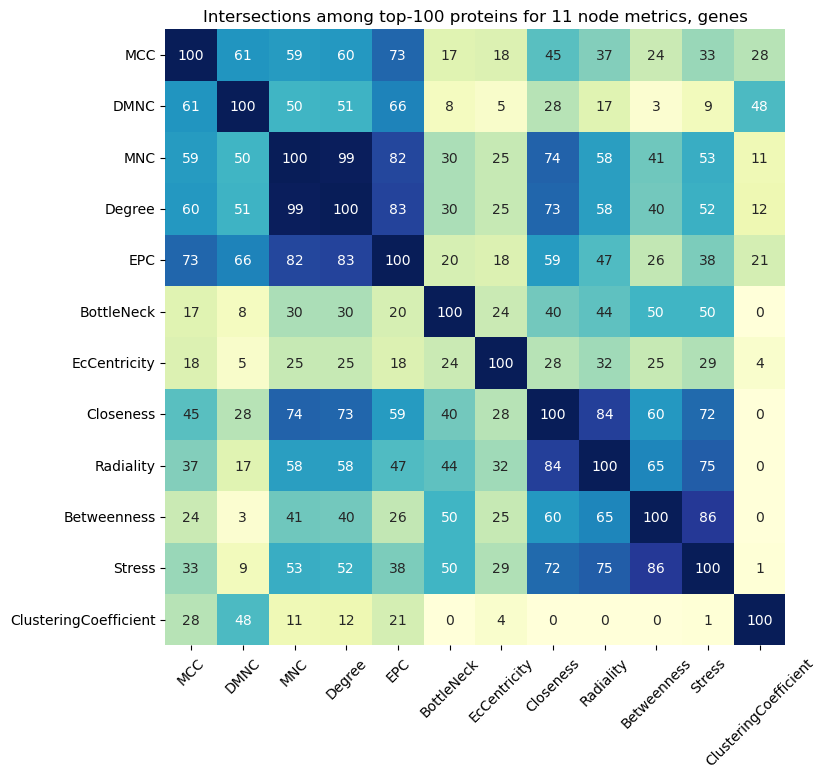

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(matrix_inters_genes.astype(float), annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)
plt.title('Intersections among top-100 proteins for 11 node metrics, genes')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# full intersections for top 100
full_intersectiong = set.intersection(*(set(top_100_dictg[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))

print(*[i+"," for i in sorted(full_intersectiong)])
print(len(full_intersectiong), "key proteins overall\n")

# for top 200
top_200_dictg, _ = top_matrix(early_int_genes, 200)
full_intersectiong = set.intersection(*(set(top_200_dictg[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))
print(*[i+"," for i in sorted(full_intersectiong)])
print(len(full_intersectiong), "key proteins overall\n")

DKC1, HSP90AA1, HSP90AB1, NCL, NOP56, RPL30,
6 key proteins overall

ACO1, DDX21, DKC1, EIF4A1, FBL, FTSJ3, HSP90AA1, HSP90AB1, MRPL3, MRTO4, NCL, NIP7, NOP14, NOP2, NOP56, NPM1, NUP107, PA2G4, PNPT1, POLR2E, PSMG1, RBM8A, RPL13, RPL27A, RPL30, RPS20, RPS4X, RRS1, SNRPE, SRSF1, SRSF2, UBQLN2, UPF1,
33 key proteins overall



### tRNA

In [ ]:
trnas = data_preprocessing(dir, "trnas_stat.csv", "trnas_stat_names.csv")
trnas.head()

,string_id,MCC,DMNC,MNC,Degree,EPC,BottleNeck,EcCentricity,Closeness,Radiality,Betweenness,Stress,ClusteringCoefficient,protein_name
0,9606.ENSP00000257829,1.028222e+13,0.62649,49.0,49.0,48.604,1.0,0.24757,122.00000,4.10751,767.30452,10934.0,0.39796,NAT10
1,9606.ENSP00000217372,1.096410e+10,0.83328,27.0,28.0,38.434,1.0,0.33010,112.00000,4.02458,142.41039,2388.0,0.59788,CDK5RAP1
2,9606.ENSP00000251607,9.223372e+13,0.67534,51.0,51.0,54.774,1.0,0.24757,123.75000,4.14166,866.19712,14176.0,0.42353,TRNT1
3,9606.ENSP00000373918,9.223372e+13,1.43085,40.0,40.0,51.812,1.0,0.24757,107.00000,3.75628,1.84257,80.0,0.97051,GARS1
4,9606.ENSP00000256854,9.223372e+13,1.37731,43.0,43.0,53.935,1.0,0.24757,108.83333,3.78067,17.97930,372.0,0.91251,NARS1


In [ ]:
top_100_dicttrna, matrix_inters_trnas = top_matrix(trnas)

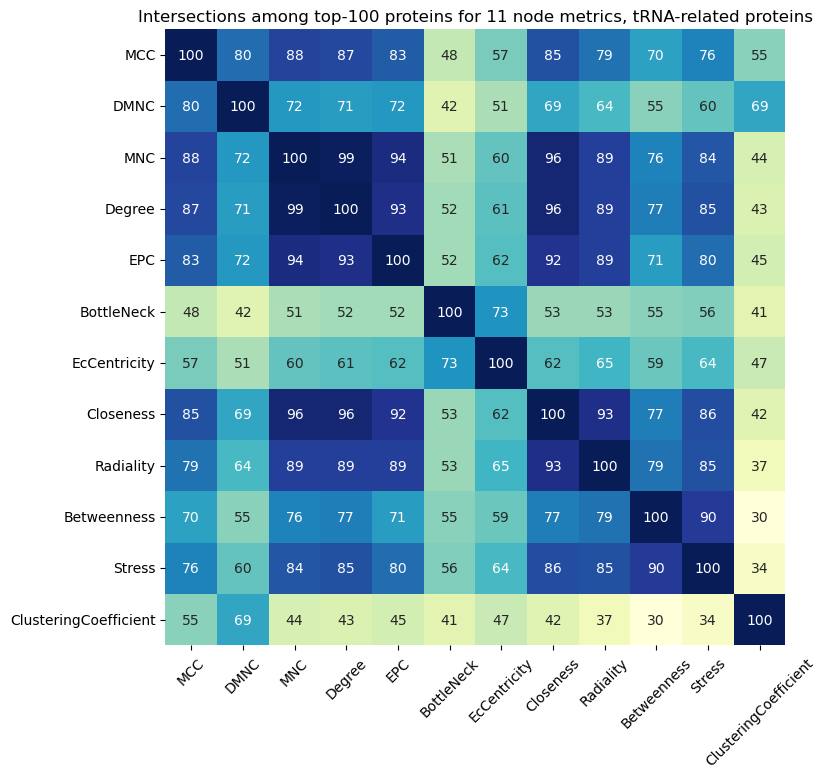

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(matrix_inters_trnas, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)
plt.title('Intersections among top-100 proteins for 11 node metrics, tRNA-related proteins')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# intersection of all metrics except DMNC, ClusteringCoefficient, and EcCentricity

full_intersectiontrna = set.union(*(set(top_100_dicttrna[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))

print(*[i+"," for i in sorted(full_intersectiontrna)])
len(full_intersectiontrna)

AARS2, CARS2, CTU1, DARS2, DUS2, EARS2, EPRS1, FTSJ1, GATB, HARS1, HARS2, IARS1, KARS1, METTL1, MTFMT, NSUN2, PUS1, PUS3, PUS7, QTRT1, RARS2, RPP38, SARS2, SARS2-2, TRIT1, TRMT1, TRMT10C, TRMT11, TRMT112, TRMT1L, TRMT5, TRUB1, WDR4, YARS1,


34

### RNA-seq (genes) - RNA-seq (transcripts) - proteomics overlap

In [ ]:
early_int3 = data_preprocessing(dir, "THREE_INTERS_CALC.csv", "THREE_INTERS_CALC_names.csv")
early_int3.head()

,string_id,MCC,DMNC,MNC,Degree,EPC,BottleNeck,EcCentricity,Closeness,Radiality,Betweenness,Stress,ClusteringCoefficient,protein_name
0,9606.ENSP00000260502,0.0,0.00000,0.0,0.0,1.000,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,BCAR3
1,9606.ENSP00000314067,40.0,0.34989,8.0,10.0,16.267,10.0,0.11310,58.90476,4.94687,1595.55605,5492.0,0.26667,PAK2
2,9606.ENSP00000260746,7.0,0.46346,3.0,4.0,23.168,6.0,0.13194,56.36667,4.94687,523.86931,2538.0,0.50000,ARL3
3,9606.ENSP00000370074,0.0,0.00000,0.0,0.0,1.000,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,SERPINB9
4,9606.ENSP00000262241,6.0,0.30779,2.0,6.0,32.890,3.0,0.11310,65.14286,5.36155,699.27041,2442.0,0.13333,RCOR1


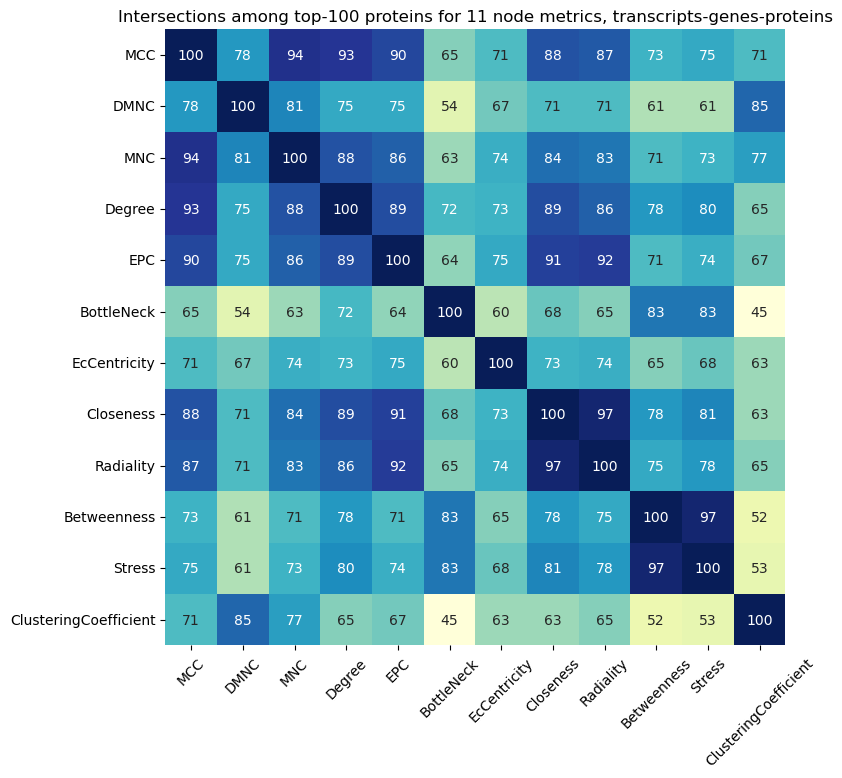

In [ ]:
top_100_dict3, matrix_inters_3 = top100_matrix(early_int3)

plt.figure(figsize=(8, 8))
sns.heatmap(matrix_inters_3, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)
plt.title('Intersections among top-100 proteins for 11 node metrics, transcripts-genes-proteins')
plt.xticks(rotation=45)

plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [ ]:
full_intersection3 = set.intersection(*(set(top_100_dict3[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))

print(*[i+"," for i in sorted(full_intersection3)])
len(full_intersection3)

AFG3L2, AGO2, AK1, ALYREF, AQR, BAZ1B, CEBPZ, CREBBP, CYC1, CYCS, DDX18, DHX9, EIF3J, FARSB, FASN, FEN1, GNL1, GSPT1, H6PD, HEXIM1, HSPA1B, IGF2BP2, LSG1, MRPL47, MRPL54, MTA2, NOP2, POLR1A, POP7, PRKDC, PSMG1, PUS1, PYGB, RPL7, RPS16, SERBP1, SF1, SF3A3, SRSF2, TFB2M, TRIM28, URB1, WDR3, WDR43, WDR77,


45

In [ ]:
full_union3 = set.union(*(set(top_100_dict3[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))

print(*[i+"," for i in sorted(full_union3)])
len(full_union3)

AFF4, AFG3L2, AGO2, AHNAK, AK1, ALDH1A3, ALDH1B1, ALYREF, AQR, ARHGAP32, ARL3, ASCC3, ATAD2, ATAD5, BAG2, BAZ1B, BCCIP, BCL2L1, BYSL, CBX5, CCDC124, CDC42BPA, CEBPZ, CHERP, CHM, CIB1, CLIP2, CREBBP, CRNKL1, CTH, CYC1, CYCS, DDX18, DDX54, DHX9, DNAJA3, DSG2, DUS3L, EIF3J, EPPK1, FAHD1, FAM91A1, FAR1, FARSB, FASN, FEN1, FKBP4, FLOT1, GCLM, GEMIN5, GIPC1, GNL1, GPT2, GSPT1, GTF2E2, H6PD, HEXIM1, HK2, HPRT1, HSPA1B, IGF2BP1, IGF2BP2, KPNA3, KRT19, LAMB1, LAMC2, LETM1, LMTK2, LSG1, MCM2, MCM3, MDN1, MRPL47, MRPL51, MRPL54, MTA2, NDC1, NDUFS6, NLE1, NOL7, NOP16, NOP2, PAK2, PES1, POLR1A, POP1, POP7, PPAT, PPM1H, PRKCI, PRKDC, PSMB2, PSMG1, PUS1, PYGB, RAB8A, RCOR1, RLF, RPAP3, RPIA, RPL7, RPS16, RPUSD2, RRN3, RRP7A, S100A10, SART3, SCRIB, SERBP1, SF1, SF3A2, SF3A3, SF3B4, SIN3A, SMCHD1, SNX18, SNX8, SOX9, SPINT1, SRSF2, STAM, STOM, SURF6, TAOK3, TFB2M, TNPO2, TOMM22, TRIM28, TRMT61A, TTF2, UNG, URB1, URB2, UTP18, UTP20, VAMP3, VAPA, VAPB, WDR3, WDR43, WDR77, XRCC1, ZW10,


143

## Late intersection

In [ ]:
dir = "/home/anna/Downloads/OE33_project/edger_deseq_inters_all_comp/global_intersection"

### Genes

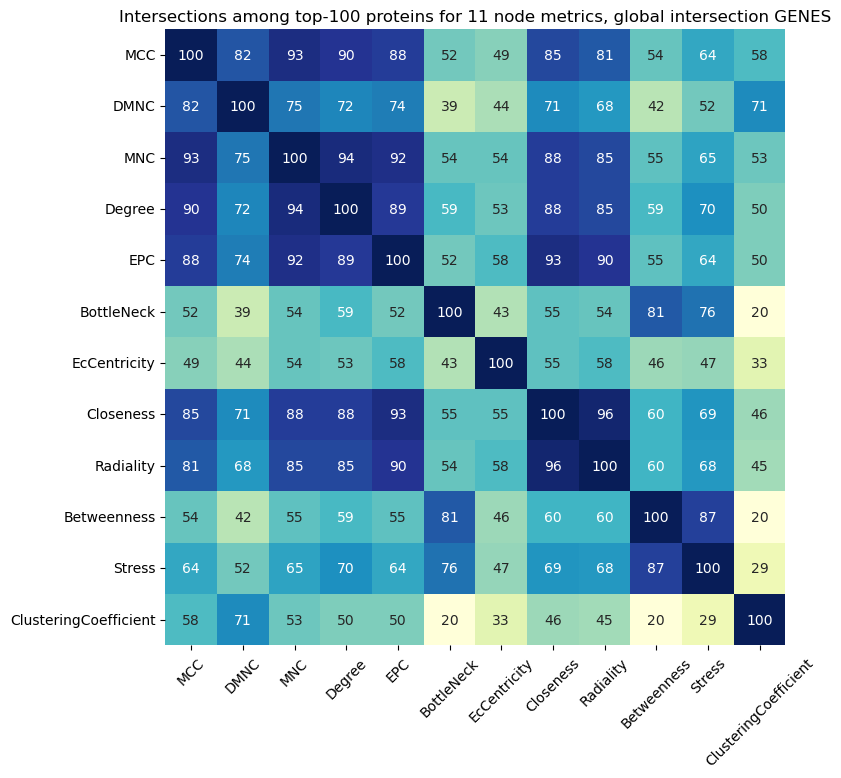

ASNS, CAD, CDC25A, CLSPN, CTPS1, DDX39A, DNMT1, ERCC6L, FARSA, FEN1, FUS, HNRNPAB, IMP3, MAPT, MAT2A, MCM3, MCM4, MCM5, MCM7, MRPL4, MSH6, MYBL2, NCL, NOP56, PCNA, PKM, POLR1A, RBL2, RECQL4, RRP9, SRSF1, TBL3, TFDP1, TONSL, TYMS, UHRF1, UTP20, YARS1,
38 key proteins overall



In [ ]:
late_int_genes = data_preprocessing(dir, "global_inters_genes_CALC.csv", "global_inters_genes_NAMES.csv")
top_100_dict, matrix_li_genes = top_matrix(late_int_genes)

plt.figure(figsize=(8, 8))
sns.heatmap(matrix_li_genes, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)
plt.title('Intersections among top-100 proteins for 11 node metrics, global intersection GENES')
plt.xticks(rotation=45)
plt.show()

# intersection of all metrics except DMNC, ClusteringCoefficient, and EcCentricity

full_intersection_lg = set.intersection(*(set(top_100_dict[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))
print(*[i+"," for i in sorted(full_intersection_lg)])
print(len(full_intersection_lg), "key proteins overall\n")


### Transcripts

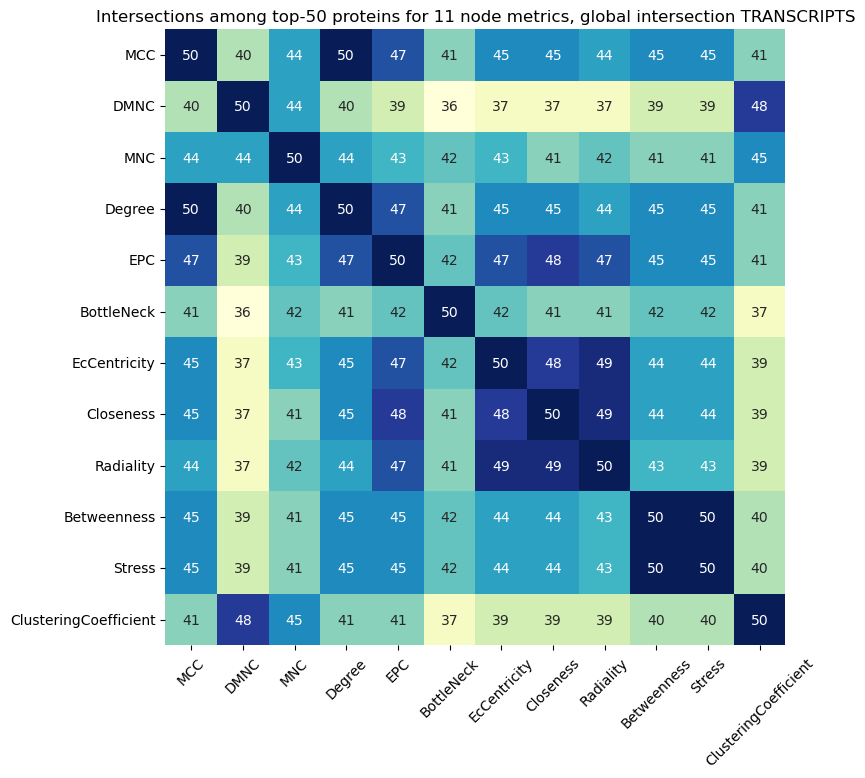

ALDH6A1, ALG3, ARG2, ASNS, ATAD3A, BOP1, CAD, CHAF1A, DCTPP1, DDX39A, DTYMK, FARSA, FEN1, FKBP4, FTL, GAB2, GADD45GIP1, MCM6, MUC16, MUC5AC, PCLAF, PCNA, POP1, PPP2R5C, RASA4, RRAS, RRP9, SARS1, SERPINE1, UNG, UTP20, WBP2, WDR76,
33 key proteins overall



In [ ]:
late_int_genes = data_preprocessing(dir, "global_inters_transcr_CALC.csv", "global_inters_transcr_NAMES.csv")
top_50_dict, matrix_li_genes = top_matrix(late_int_genes, 50)

plt.figure(figsize=(8, 8))
sns.heatmap(matrix_li_genes, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)
plt.title('Intersections among top-50 proteins for 11 node metrics, global intersection TRANSCRIPTS')
plt.xticks(rotation=45)
plt.show()

# intersection of all metrics except DMNC, ClusteringCoefficient, and EcCentricity

full_intersection_lt = set.intersection(*(set(top_50_dict[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))

print(*[i+"," for i in sorted(full_intersection_lt)])
print(len(full_intersection_lt), "key proteins overall\n")


In [ ]:
# Intersection between key genes and transcripts
full_intersection_lg.intersection(full_intersection_lt)

{'ASNS', 'CAD', 'DDX39A', 'FARSA', 'FEN1', 'PCNA', 'RRP9', 'UTP20'}

### Genes - trs intersection

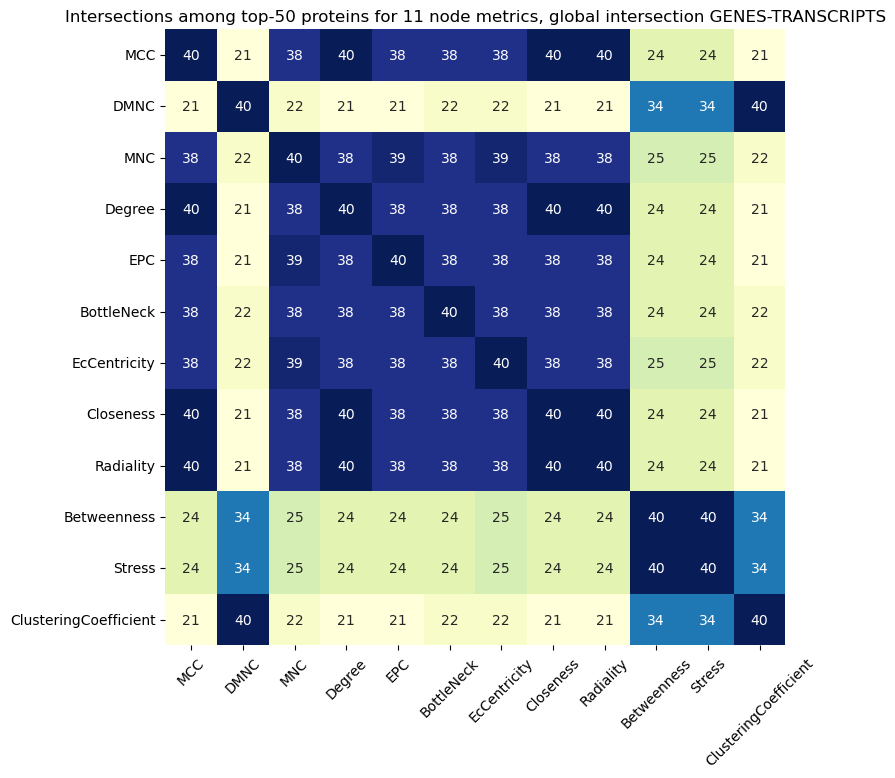

ASF1B, ASNS, BAZ1B, BOP1, CA12, CAD, CHAF1A, DDX39A, DTYMK, E2F2, FAM83E, FARSA, FEN1, MCM6, PCLAF, PCNA, PSG2, PSG4, RRP9, SARS1, SERPINE1, TTLL11, UNG, UTP20,
24 key proteins overall



In [ ]:
late_int_genes = data_preprocessing(dir, "global_inters_genes_trs_CALC.csv", "global_inters_genes_trs_NAMES.csv")
top_50_dict, matrix_li_genes = top_matrix(late_int_genes, 40)

plt.figure(figsize=(8, 8))
sns.heatmap(matrix_li_genes, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)
plt.title('Intersections among top-50 proteins for 11 node metrics, global intersection GENES-TRANSCRIPTS')
plt.xticks(rotation=45)
plt.show()

# intersection of all metrics except DMNC, ClusteringCoefficient, and EcCentricity

full_intersection_lgt = set.intersection(*(set(top_50_dict[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))

print(*[i+"," for i in sorted(full_intersection_lgt)])
print(len(full_intersection_lgt), "key proteins overall\n")


## Proteomics

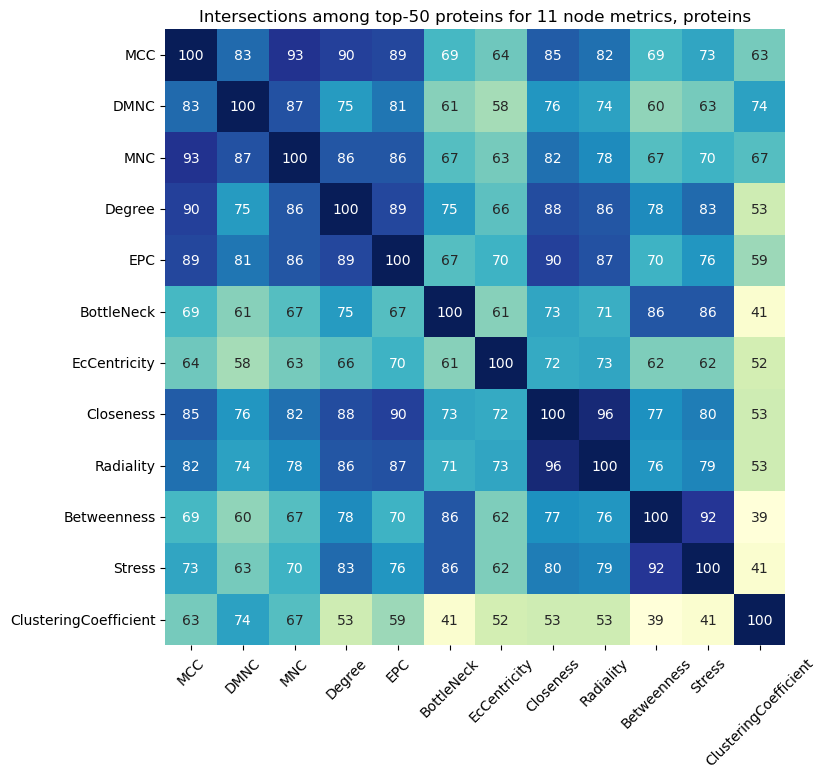

ARF1, ASS1, BCAP31, CANX, CDC45, CDYL, COPB1, CTPS1, DDX20, DHX38, DIAPH3, DICER1, EED, EIF4A1, ERP44, GLUD1, IDH2, KDM1A, KIF15, LMAN1, LTN1, MRE11, MRPL32, MRPL34, MT-ATP6, MTHFD1L, NOP10, NOP14, NVL, PAK2, PES1, PPIB, PRC1, PRDX2, PSMB1, PYGB, RFC3, RPL11, RPL21, RPS15, RPS20, RPS23, SERBP1, SRRT, SRSF11, SSB, TOP1, TXN, UTP18, VARS1,
50 key proteins overall



In [ ]:
dir = "/home/anna/Downloads/OE33_project/Proteomics_20230721d_JR_HS_METTL1_KO/reps3nc2_analysis"
late_int_genes = data_preprocessing(dir, "proteins_stats.csv", "proteins_names.csv")
top_100_dict, matrix_prots = top_matrix(late_int_genes, 100)

plt.figure(figsize=(8, 8))
sns.heatmap(matrix_prots, annot=True, fmt=".0f", cmap="YlGnBu", cbar=False)
plt.title('Intersections among top-50 proteins for 11 node metrics, proteins')
plt.xticks(rotation=45)
plt.show()

# intersection of all metrics except DMNC, ClusteringCoefficient, and EcCentricity

full_intersection_p = set.intersection(*(set(top_100_dict[key]) for key in ['MCC', 'MNC', 'Degree', 'EPC',
                                                                             'BottleNeck', 'Closeness', 'Radiality',
                                                                             'Betweenness', 'Stress']))

print(*[i+"," for i in sorted(full_intersection_p)])
print(len(full_intersection_p), "key proteins overall\n")


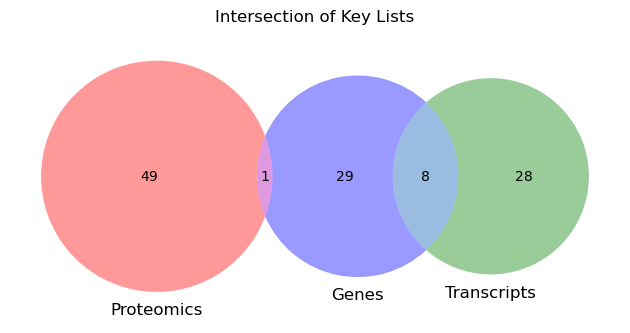

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Define the lists
proteomics_key_prots = [
    'ARF1', 'ASS1', 'BCAP31', 'CANX', 'CDC45', 'CDYL', 'COPB1', 'CTPS1', 'DDX20', 'DHX38',
    'DIAPH3', 'DICER1', 'EED', 'EIF4A1', 'ERP44', 'GLUD1', 'IDH2', 'KDM1A', 'KIF15', 'LMAN1',
    'LTN1', 'MRE11', 'MRPL32', 'MRPL34', 'MT-ATP6', 'MTHFD1L', 'NOP10', 'NOP14', 'NVL', 'PAK2',
    'PES1', 'PPIB', 'PRC1', 'PRDX2', 'PSMB1', 'PYGB', 'RFC3', 'RPL11', 'RPL21', 'RPS15', 'RPS20',
    'RPS23', 'SERBP1', 'SRRT', 'SRSF11', 'SSB', 'TOP1', 'TXN', 'UTP18', 'VARS1'
]

transcripts_key = [
    'DDX39A', 'RAVER1', 'ASNS', 'CAD', 'UNG', 'UTP20', 'WDR76', 'DTYMK', 'BOP1', 'BACE1',
    'CPSF7', 'PCNA', 'ASF1B', 'HNRNPH1', 'PCLAF', 'AK7', 'FEN1', 'CHAF1A', 'PRPF19', 'NOP53',
    'E2F2', 'FARSA', 'SARS1', 'MCM6', 'DCTPP1', 'PIGA', 'ARG2', 'RBM12B', 'BAZ1B', 'RRP9',
    'POP1', 'GADD45GIP1', 'PLK2', 'HNRNPA1', 'SRSF2', 'ALG3'
]

genes_key = [
    'DDX39A', 'ASNS', 'ERCC6L', 'POLR1A', 'CAD', 'UTP20', 'MRPL4', 'TBL3', 'UHRF1', 'MSH6',
    'MCM4', 'MCM3', 'FUS', 'YARS1', 'MCM7', 'IMP3', 'PCNA', 'MAPT', 'MAT2A', 'MYBL2', 'CTPS1',
    'CLSPN', 'FEN1', 'TFDP1', 'HNRNPAB', 'FARSA', 'TYMS', 'RECQL4', 'NCL', 'SRSF1', 'DNMT1',
    'RBL2', 'NOP56', 'CDC25A', 'TONSL', 'RRP9', 'MCM5', 'PKM'
]

# Create the Venn diagram
venn3(subsets=(set(proteomics_key_prots), set(transcripts_key), set(genes_key)),
      set_labels=('Proteomics', 'Transcripts', 'Genes'))
plt.title("Intersection of Key Lists")
plt.tight_layout()
plt.savefig("key_intersections.png", bbox_inches='tight')


In [ ]:
# Calculate pairwise intersections
proteins_transcripts_intersection = set(proteomics_key_prots).intersection(set(transcripts_key))
proteins_genes_intersection = set(proteomics_key_prots).intersection(set(genes_key))
transcripts_genes_intersection = set(transcripts_key).intersection(set(genes_key))

# Print the pairwise intersections along with the names of the genes
print("Intersection between Proteomics Key Proteins and Transcripts Key:")
print(proteins_transcripts_intersection)
print("\nIntersection between Proteomics Key Proteins and Genes Key:")
print(proteins_genes_intersection)
print("\nIntersection between Transcripts Key and Genes Key:")
print(transcripts_genes_intersection)


Intersection between Proteomics Key Proteins and Transcripts Key:
set()

Intersection between Proteomics Key Proteins and Genes Key:
{'CTPS1'}

Intersection between Transcripts Key and Genes Key:
{'CAD', 'RRP9', 'UTP20', 'ASNS', 'PCNA', 'FARSA', 'FEN1', 'DDX39A'}


In [ ]:
#full_list = list(set(proteomics_key_prots + transcripts_key + genes_key))
#for name in sorted(full_list):
#    check = [name in proteomics_key_prots, name in transcripts_key, name in genes_key]
#    #print(name)
#    print(*np.array([1,2,3])[check])

# Calculating number of edges between networks

Here we will look at which proteins have the highest number of edges between the network of tRNA-related proteins (derived from GO terms) and the networks of key proteins derived from RNA-seq and proteomics:

In [ ]:
cytoscape_network_file1 = "trnas_key_merged.cyjs"
cytoscape_network_file2 = "poi_key_merged.cyjs"
cytoscape_network_file3 = "poi_key_prots_merged.cyjs"
G1 = cyjs2graph(cytoscape_network_file1)
G2 = cyjs2graph(cytoscape_network_file2)
G3 = cyjs2graph(cytoscape_network_file3)

In [ ]:
!ls .

genes_metrics_intersection.png	   poi_key_prots_merged.cyjs
heatmap.png			   trnas_key_merged.cyjs
networks_trnas_intersection.ipynb  trnas_key_merged.sif
poi_extended_57.cyjs		   trs_metrics_intersection.png
poi_key_merged.cyjs


In [ ]:
!pwd

/home/anna/Downloads/OE33_project/cytoscape_res/tRNAs


In [ ]:
# for proteins
with open("../key_prots_genenames.txt", "r") as file:
    nodes_to_group1 = [line.strip() for line in file]

group1_nodes = set(nodes_to_group1) # key prots/genes
group2_nodes = set(G.nodes) - group1_nodes  # rest of the network

# add node attributes for group information
node_groups = {node: 1 if node in group1_nodes else 2 for node in G.nodes}
nx.set_node_attributes(G, node_groups, "group")

In [ ]:
# selecting edges connecting the two groups
edges_bw_groups = set()
for edge in G.edges:
    source, target = edge
    if source in group1_nodes and target in group2_nodes:
        edges_bw_groups.add(edge)
    elif target in group1_nodes and source in group2_nodes:
        edges_bw_groups.add(edge)

In [ ]:
# calculating number of edges for ALL nodes
set_k = dict()
for s in edges_bw_groups:
    if s[0] in set_k.keys():
        set_k[s[0]] += 1
    else:
        set_k[s[0]]=1

In [ ]:
# printing the list
sorted_dict = dict(sorted(set_k.items(), key=lambda item: item[1], reverse=True))
for key in sorted_dict.keys():
    if key in group1_nodes:
        print(key, "-", sorted_dict[key])

BRIX1 - 12
NOP14 - 11
GNL3 - 7
RPL11 - 5
GAPDH - 4
RPS23 - 4
RPS15 - 3
PRC1 - 2
IDH2 - 2
EIF4A1 - 1
RPS20 - 1
PRDX2 - 1
DICER1 - 1


In [ ]:
for key in sorted_dict.keys():
    if key in group2_nodes:
        print(key, "-", sorted_dict[key])

FTSJ3 - 6
NSUN2 - 6
RRP8 - 5
NSUN7 - 5
MRM2 - 5
TRMT2A - 4
NOP2 - 4
NSUN4 - 4
TRUB2 - 4
TRMT6 - 4
NSUN3 - 4
TRMT61A - 3
DUS1L - 3
TRMT61B - 3
PUS3 - 3
TRMT2B - 3
WDR4 - 3
PUS7L - 2
NSUN6 - 2
BUD23 - 2
TRUB1 - 2
PUS1 - 2
TET3 - 2
WDR74 - 2
TRMT1 - 2
FTSJ1 - 2
TRMT1L - 2
NSUN5 - 2
DUS3L - 2
TARBP1 - 2
TRMT11 - 1
TET1 - 1
TET2 - 1
TRDMT1 - 1
THUMPD1 - 1
NAT10 - 1
DUS2 - 1
